This is a simple Jupyter notebook to predict the sigma profile of any compound of interest.

Start by importing the necessary dependancies.

In [1]:
# General
import pickle

# Specific
import numpy
import tensorflow
import spektral
from spektral import transforms
import networkx
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import rdForceFieldHelpers as rdFF
from matplotlib import pyplot as plt

Define the SMILES stirng of the desired molecule. Phenylalanine in this example.

In [2]:
SMILES='c1ccc(cc1)C[C@@H](C(=O)O)N'

Build the MMFF-based molecular graph for the SMILES string of interest.

In [3]:
# Obtain RDKit mol object
molecule=Chem.MolFromSmiles(SMILES)
# Make hydrogens explicit
molecule=AllChem.AddHs(molecule)
# Generate initial 3D structure of the molecule
AllChem.EmbedMolecule(molecule)
# Initialize MMFF props object
prop=rdFF.MMFFGetMoleculeProperties(molecule)
# Check if MMFF exists for entry
if prop is None:
    raise ValueError('Cannot describe requested molecule using MMFF.')
else:
    # Initialize container
    atomTypes=[]
    # Retrieve node-level features
    for atom in molecule.GetAtoms():
        # Get MMFF atom type
        atomType=prop.GetMMFFAtomType(atom.GetIdx())
        # Append
        atomTypes.append(atomType)

Draw the moolecue and its corresponding MMFF-based graph.

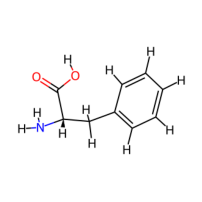

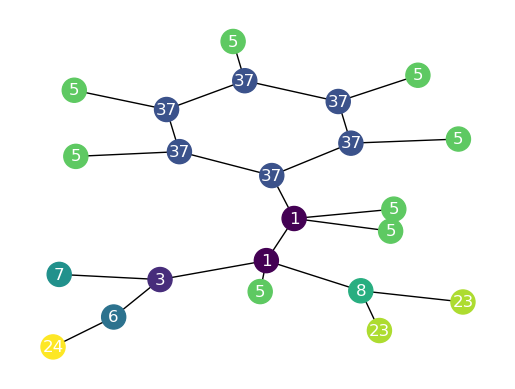

In [4]:
# Draw RDKit Molecule
fig=plt.figure()
axes=plt.axes([0.6, 0.47, 0.38, 0.38],frameon=True)
axes.imshow(Draw.MolToImage(molecule))
axes.axis('off')
plt.show()
plt.clf()
# Initialize empty NetworkX graph
graph=networkx.Graph()
# Add nodes by looping over atoms in molecule
for n,atom in enumerate(molecule.GetAtoms()):
    attribute={'feature':atomTypes[n]}
    # Add node to graph
    graph.add_nodes_from([(atom.GetIdx(),attribute)])
# Add edges by looping over bonds in molecule
for bond in molecule.GetBonds():
    # Add edge to graph
    graph.add_edges_from([(bond.GetBeginAtomIdx(),
                           bond.GetEndAtomIdx())])
# Define layout (kamada_kawai_layout is an excellent option for molecules)
layout=networkx.kamada_kawai_layout(graph)
# Plot graph
labels=networkx.get_node_attributes(graph,'feature')
nodeFeatures=list(labels.values())
uniqueFeatures=set(nodeFeatures)
colorScheme=numpy.linspace(0,1000,num=len(uniqueFeatures)).round()
colorDict=dict(zip(uniqueFeatures,colorScheme))
replacer=colorDict.get
colorList=[replacer(n,n) for n in nodeFeatures]
networkx.draw_networkx(graph,pos=layout,
                       node_color=colorList,
                       labels=labels,
                       font_color='w')
plt.axis('off')
plt.show()

Build the node-level feature matrix of the graph by one-hot encoding MMFF atom types.

In [5]:
# Define available unique MMFF atom types (F)
uniqueAtomTypes=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,18,20,21,22,23,24,25,
                 26,27,28,29,30,31,32,33,35,37,38,39,40,42,43,44,45,59,61,63,
                 64,65,66,70,71,72,74]
# Initialize node-level feature matrix (X) of size NxF
X=numpy.zeros((len(atomTypes),len(uniqueAtomTypes)))
# Iterate over atomTypes
for n in range(len(atomTypes)):
    # Check that atom type it is available
    if atomTypes[n] not in uniqueAtomTypes:
        raise ValueError('Molecule contains atoms not trained on the GCN.')
    # Map force field atom type to index in uniqueAtomTypes
    oneHotIndex=uniqueAtomTypes.index(atomTypes[n])
    # One-hot encode atom n
    oneHot=spektral.utils.one_hot(oneHotIndex,len(uniqueAtomTypes))
    # Add entry to X
    X[n,:]=oneHot

Build a Spektral graph dataset object for the graph.

In [6]:
class graphDataset(spektral.data.Dataset):
    """
    spektral.data.Dataset object containing the spektral graph objects of the
    molecules in any given dataset.
    """
    def __init__(self,graph):
        self.graph=graph
        super().__init__()
    def read(self):
        dataset=[self.graph]
        return dataset
# Get adjacency matrix
adjacencyMatrix=Chem.GetAdjacencyMatrix(molecule).astype('float32')
# Builg graph
graph=spektral.data.graph.Graph(x=X,a=adjacencyMatrix,e=None,y=numpy.ones((51,)))
# Convert to dataset
graphSet=graphDataset(graph)

Define the GCN model.

In [7]:
#---- Define GCN model
class GCN_Model_SP(tensorflow.keras.models.Model):
    """
    tensorflow.keras.models.Model object containing the architecture of the
    graph neural network model for sigma profile regression.
    """
    def __init__(self,architecture):
        """
        __init__() constrcuts the architecture of the model.

        Parameters
        ----------
        architecture : dict
            See configuration section.

        Returns
        -------
        None.

        """
        super().__init__()
        # Unpack architecture
        conv1_channels=architecture.get('conv1_channels')
        conv2_channels=architecture.get('conv2_channels')
        conv3_channels=architecture.get('conv3_channels')
        reg=tensorflow.keras.regularizers.L2(architecture.get('L2 coeff.'))
        ki='he_uniform'
        # Define userLayers list
        self.userLayers=[]
        # First conv layer
        if conv1_channels>0:
            conv1Layer=spektral.layers.GCNConv(conv1_channels,
                                               activation='relu',
                                               kernel_initializer=ki,
                                               kernel_regularizer=reg,
                                               use_bias=False)
            self.userLayers.append(conv1Layer)
        # Second conv layer
        if conv2_channels>0:
            conv2Layer=spektral.layers.GCNConv(conv2_channels,
                                               activation='relu',
                                               kernel_initializer=ki,
                                               kernel_regularizer=reg,
                                               use_bias=False)
            self.userLayers.append(conv2Layer)
        # Third conv layer
        if conv3_channels>0:
            conv3Layer=spektral.layers.GCNConv(conv3_channels,
                                               activation='relu',
                                               kernel_initializer=ki,
                                               kernel_regularizer=reg,
                                               use_bias=False)
            self.userLayers.append(conv3Layer)
        # Dense layer (X*W)
        dense=tensorflow.keras.layers.Dense(51,
                                            activation='relu',
                                            kernel_initializer=ki,
                                            kernel_regularizer=reg,
                                            use_bias=False)
        self.userLayers.append(dense)
        # Pooling layer
        poolLayer=spektral.layers.GlobalSumPool()
        self.userLayers.append(poolLayer)
    def call(self, inputs):
        """
        call() propagates "inputs" through GCN model.

        Parameters
        ----------
        inputs : tuple
            Tuple containing the adjacency tensor (batch,N,N) and the feature
            tensor (batch,N,F).

        Returns
        -------
        x : tf.Tensor
            Tensor containg the predicted sigma profiles (batch,1,51).

        """
        # Extract node feature vector (x) and adjacency matrix (a) from inputs
        X,A=inputs
        # Conv layers:
        for n in range(len(self.userLayers)-2):
            X=self.userLayers[n]([X,A])
        # Dense layer (X*W)
        X=self.userLayers[-2](X)
        # Pooling layer
        X=self.userLayers[-1](X)
        # Output
        return X

Load the GCN model weights and compile.

In [8]:
# Path to Model
modelPath=r'/path/to/Main\Models\MMFF_GCN.pkl'
# Load weights
with open(modelPath,'rb') as f:
      weights=pickle.load(f)
# Define architecture
architecture={'conv1_channels': weights[0].shape[1],
              'conv2_channels': weights[1].shape[1],
              'conv3_channels': weights[2].shape[1]}
# Build model
GCN=GCN_Model_SP(architecture)
# Compile model
GCN.compile()
# Create loader
loader=spektral.data.BatchLoader(graphSet,shuffle=False)
# Set model shape
GCN.fit(loader.load(),steps_per_epoch=loader.steps_per_epoch,epochs=1)
# Set weights
GCN.set_weights(weights)

1/1 [==============================] - 1s 933ms/step - loss: 13.3393


Predict the sigma profile.

In [9]:
# Apply filters to adjacency matrices
graphSet.apply(transforms.GCNFilter())
# Predict sigma profile
loader=spektral.data.BatchLoader(graphSet,shuffle=False)
predSP=GCN.predict(loader.load(),steps=loader.steps_per_epoch)

1/1 [==============================] - 0s 110ms/step


Plot predicted sigma profile.

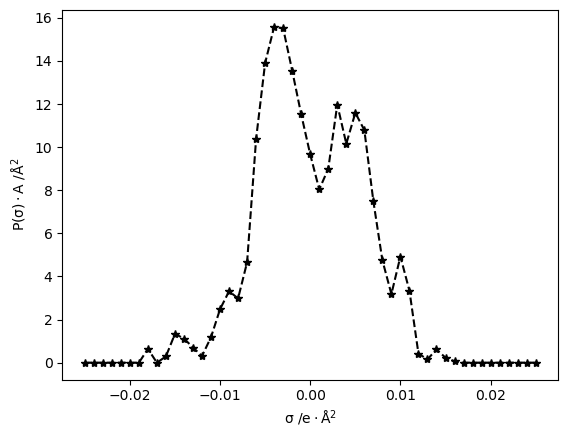

In [10]:
sigma=numpy.linspace(-0.025,0.025,51)
plt.plot(sigma,predSP[0,:],'--*k')
plt.xlabel(r'$\rm\sigma$ $\rm/e\cdotÅ^{2}$')
plt.ylabel(r'$\rm P(\sigma) \cdot A$ $\rm/Å^{2}$')
plt.show()